In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

states = torch.tensor([0, 1, 2])
Transition = torch.tensor([[0, 1/2, 1/2],
                           [1/2, 0, 1/2],
                           [1/2, 1/2, 0]])
obs = torch.tensor([0, 0, 2, 1, 1, 2])
Observation = torch.tensor([[0, 1/2, .99],
                            [0, 1/2, 0],
                            [1, 0, .01]]).T
Duration = torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]])

tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000],
        [0.9900, 0.9900, 0.0100, 0.0000, 0.0000, 0.0100]], requires_grad=True)


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_16396/3370314256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Observation[:, obs]).requires_grad_(True)


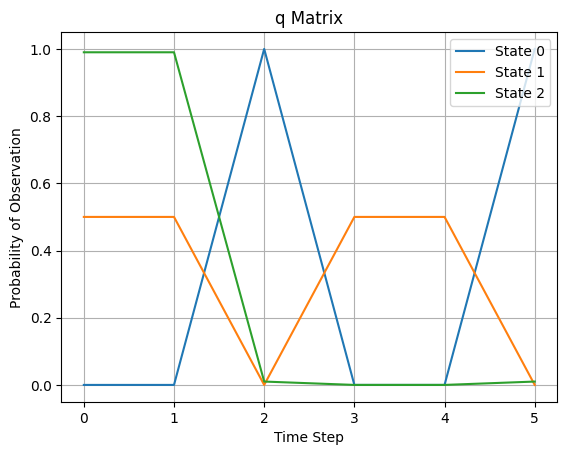

In [17]:
def q_matrix(obs, Observation):
    return torch.tensor(Observation[:, obs]).requires_grad_(True)

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = torch.exp(log_alpha_row)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

q.grad None
[[3.3333341e-09 1.6666662e-09 3.3000023e-09]
 [2.4833342e-17 8.3333328e-02 3.2669978e-09]
 [4.1666664e-02 2.4916655e-17 3.2670030e-03]
 [1.6334996e-11 1.1233406e-10 2.3724981e-18]
 [5.6166990e-19 5.6167073e-03 4.1666561e-20]
 [2.8083536e-03 6.0250797e-19 2.8083566e-13]]


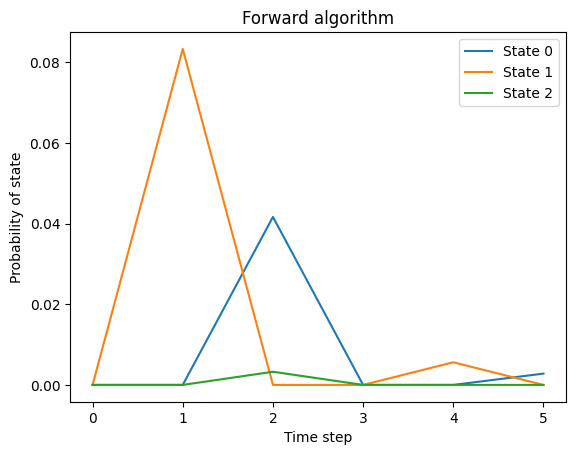

In [19]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha_list = []
    start = torch.tensor([1/3, 1/3, 1/3])
    epsilon = 1e-8

    # initialization
    for t in range(D):
        new_log_alpha = torch.log(start+epsilon) + torch.log(Duration[:, t]+epsilon) + torch.sum(torch.log(q[:, :t+1]+epsilon), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition+epsilon)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition+epsilon)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]+epsilon) + torch.sum(torch.log(q[:, t-d:t+1]+epsilon), dim=1)).squeeze()
        log_alpha_list.append(new_log_alpha)
    
    
    # fill log_alpha[D:]
    for t in range(D, T):
        log_alpha_list.append(torch.full((N,), -float('inf')))
        new_log_alpha = log_alpha_list[t]
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition+epsilon)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition+epsilon)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]+epsilon) + torch.sum(torch.log(q[:, t-d:t+1]+epsilon), dim=1)).squeeze()
        log_alpha_list[t] = new_log_alpha 

    log_alpha = torch.exp(torch.stack(log_alpha_list))
    log_alpha_sum = torch.sum(log_alpha)
    return log_alpha


fwd = forward(states, Transition, obs, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

q.grad None
[[2.3590654e-10 1.5778136e-10 7.8125013e-11]
 [6.2812494e-10 3.1250000e-02 3.1250000e-02]
 [6.2500000e-02 1.2500002e-09 6.2500000e-02]
 [3.7499919e-09 2.0075022e-16 3.7499919e-09]
 [1.0049999e-08 5.0000000e-01 5.0000000e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00]]


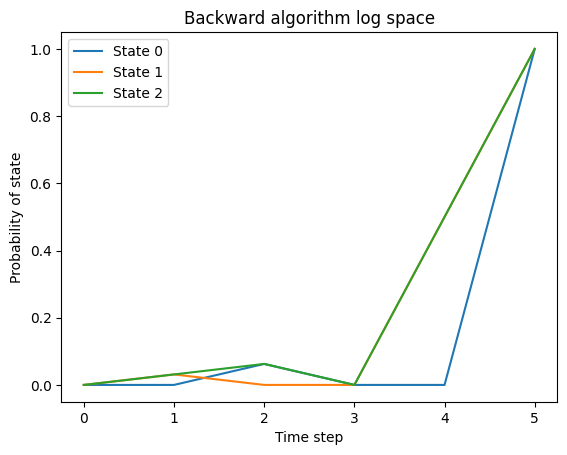

In [20]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-8
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta_new = log_beta.clone()
    log_beta_new[-1] = torch.zeros(N)
    log_beta = log_beta_new
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta_new = log_beta.clone()
                log_beta_new[t] = torch.logaddexp(log_beta[t], torch.logsumexp(torch.row_stack([log_beta[t+d+1]]*N) + torch.log(Transition + epsilon) + torch.log(torch.row_stack([Duration[:, d]]*N) + epsilon) + torch.sum(torch.log(q[:, t + 1:t + d + 2] + epsilon), axis=1), axis=1))
                log_beta = log_beta_new
                
    log_beta = torch.exp(log_beta)
    log_beta_sum = torch.sum(log_beta)
    # log_beta_sum.backward()

    return log_beta


bwd = backward(states, Transition, obs, q, Duration).detach().numpy()
print('q.grad', q.grad)
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

q.grad: tensor([[  0,   0,  -7,   0,   0,   0],
        [-13, -13,   0,   0,   0,   0],
        [  7,   7, 674,   0,   0,   0]], dtype=torch.int32)
[[2.80005799e-16 9.36380894e-17 9.18020926e-17]
 [5.55430100e-24 9.27292943e-01 3.63535690e-08]
 [9.27292943e-01 1.10904211e-23 7.27072582e-02]
 [2.18121042e-17 8.03000290e-24 3.16799440e-24]
 [2.00999688e-24 1.00000000e+00 7.41832531e-18]
 [1.00000000e+00 2.14541349e-16 1.00000105e-10]]


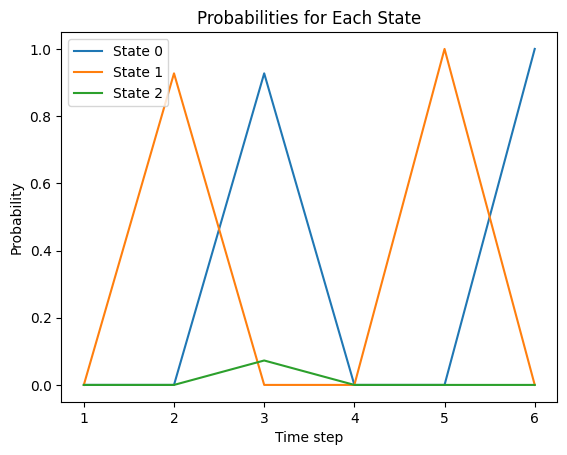

In [21]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration)
    beta = backward(states, Transition, obs, q, Duration)
    fb_probs = alpha * beta

    # normalize
    fb_sum = torch.sum(alpha[T-1])
    if fb_sum:
        fb_probs = fb_probs / fb_sum
    
    (fb_probs[2][2]).backward()
    return fb_probs

fb_probs = fb_alg(states, Transition, obs, q, Duration).detach().numpy()
print('q.grad:', (q.grad * 100).round().int())
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), probs, label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()